In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import os
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
#from sklearn.metrics import f1_score,balanced_accuracy_score,roc_curve,auc,fbeta_score,matthews_corrcoef,roc_auc_score

import pickle
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer
#from sklearn.linear_model import BayesianRidge
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
#from sklearn.impute import KNNImputer
#from sklearn.svm import SVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import StratifiedShuffleSplit
#from imblearn.under_sampling import CondensedNearestNeighbour,RandomUnderSampler
#from sklearn.metrics import balanced_accuracy_score
#import os
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.model_selection import StratifiedKFold

In [23]:
from sklearn.metrics import precision_recall_curve,roc_curve

In [2]:
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import BayesSearchCV

In [3]:
df = pd.read_pickle('Cleaned Trucks Data.pickle')
df.drop('90',axis=1,inplace=True)

In [94]:
df = df.loc[:,df.isna().mean()<0.5]

In [97]:
corrs = df.corr()['class'][1:]

In [113]:
y = df[['class']]

In [114]:
X = df.loc[:,corrs[corrs.abs()>0.3].index]

In [ ]:
X = df.loc[:,'1':]
y = df[['class']]

In [47]:
Xt = df.loc[:,'1':]
yt = df[['class']]

In [92]:
temp=Xt['95'].copy()
temp.values[:]=1
temp[Xt[Xt['95']<9221245].index]=0
cm = confusion_matrix(yt,temp)
cm[0][1]*10+cm[1][0]*500

72820

In [22]:
Xneg = X[df['class']==0]

In [19]:
imputer = SimpleImputer()
Xneg = imputer.fit_transform(Xneg)

In [28]:
under = df.loc[Xneg.sample(1000).index.tolist()+X[df['class']==1].index.tolist()]

<AxesSubplot:xlabel='class', ylabel='95'>

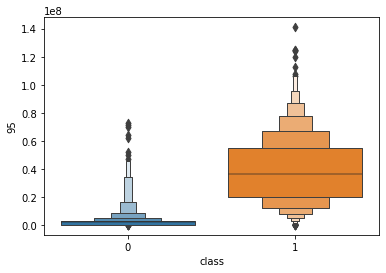

In [30]:
sns.boxenplot(x='class',y='95',data=under)

In [32]:
X = under.loc[:,'1':]
y = under[['class']]

In [99]:
def optimize_cost(X_train,y_train,X_test,y_test,col):     
    bv = (X_train[col].max()+X_train[col].min())/2
    gap = np.abs(bv)
    lc = 0
    bestvalue = []
    flag = 0
    while(bv-gap != bv+gap):
        flag += 1
        for i in np.arange(bv-gap,bv+gap,(2*gap)/(100/flag**2)):
            temp=X_train[col].copy()
            temp.values[:]=1
            temp[X_train[X_train[col]<i].index]=0
            #cm = confusion_matrix(y_train,temp)
            score = roc_auc_score(y_train,temp,average='weighted')
            bestvalue.append((i,score))
        bestvaluedf = pd.DataFrame(bestvalue).set_index(0)
        bestvalue = []
        bv = float(bestvaluedf.idxmax().values)
        lscore = float(bestvaluedf.max().values)
        gap = (np.abs(bv)*0.1)/flag**4
        if flag == 1:
            bestvaluedf.plot()
            plt.title('Cost function optimization on Train data')
            plt.ylabel('Score')
            plt.xlabel('Column {} value'.format(col))   
            plt.tight_layout()
        if ((bestvaluedf.max()/bestvaluedf.min()) < 1.001).values[0]:
            break
    #lc = cm[0][1]*10*50+cm[1][0]*500
    print('best value of column \'{}\' from train data:'.format(col),bv)
    #print('\nleast cost on train data:',lc)
    print('score on train data:',lscore)

    temp=X_test[col].copy()
    temp.values[:]=1
    temp[X_test[X_test[col]<bv].index]=0
    #cm = confusion_matrix(y_test,temp)
    #lc = cm[0][1]*10*50+cm[1][0]*500
    score = roc_auc_score(y_test,temp,average='weighted')
    #print('\nleast cost on test data:',lc)
    print('score on test data:',score);

In [43]:
def optimize_cost(X_train,y_train,X_test,y_test,col):     
    cv = StratifiedKFold(n_splits=5,random_state=42)
    bvs = []

    for train_fold_index, val_fold_index in cv.split(X_train,y_train):

        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]

        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        bv = (X_train_fold[col].max()+X_train_fold[col].min())/2
        gap = np.abs(bv)
        lc = 0
        bestvalue = []
        flag = 0
        while(bv-gap != bv+gap):
            flag += 1
            for i in np.arange(bv-gap,bv+gap,(2*gap)/(100/flag**2)):
                temp=X_train_fold[col].copy()
                temp.values[:]=1
                temp[X_train_fold[X_train_fold[col]<i].index]=0
                cm = confusion_matrix(y_train_fold,temp)
                score = cm[0][1]*10+cm[1][0]*500
                bestvalue.append((i,score))
            bestvaluedf = pd.DataFrame(bestvalue).set_index(0)
            bestvalue = []
            bv = float(bestvaluedf.idxmin().values)
            lscore = float(bestvaluedf.min().values)
            gap = (np.abs(bv)*0.1)/flag**4
            if flag == 1:
                bestvaluedf.plot()
                plt.title('Cost function optimization on Train data')
                plt.ylabel('Excess cost score related to APS')
                plt.xlabel('Column {} value'.format(col))   
                plt.tight_layout()
                plt.show()
            if ((bestvaluedf.max()/bestvaluedf.min()) < 1.001).values[0]:
                break
        #lc = cm[0][1]*10+cm[1][0]*500
        print('best value of column \'{}\' from train data:'.format(col),bv)
        bvs.append(bv)
        #print('\nleast cost on train data:',lc)
        print('score on train data:',lscore)
    print('\nBest values from 5 train sets:',bvs)
    print('\nAverage best value of column \'{}\' from train data:'.format(col),np.mean(bvs))
    temp=X_test[col].copy()
    temp.values[:]=1
    temp[X_test[X_test[col]<np.mean(bvs)].index]=0
    cm = confusion_matrix(y_test,temp)
    score = cm[0][1]*10+cm[1][0]*500
    #score = lc / cm.sum()
    #print('\nleast cost on test data:',lc)
    print('\nScore on test data:',score);

c:\users\hari\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


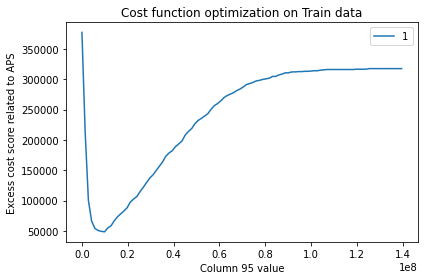

best value of column '95' from train data: 9225825.469570167
score on train data: 47010.0


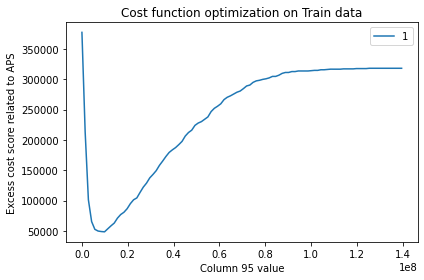

best value of column '95' from train data: 10265016.124660507
score on train data: 47380.0


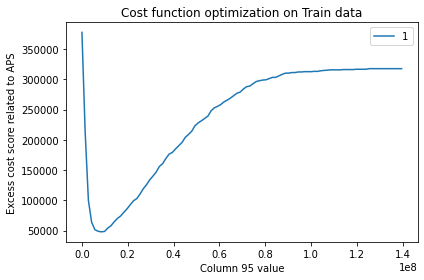

best value of column '95' from train data: 9225446.934447868
score on train data: 46820.0


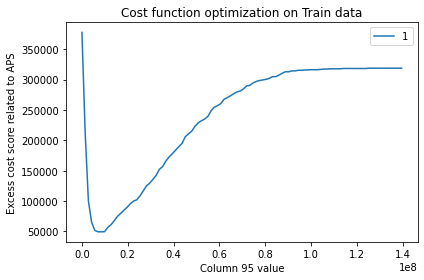

best value of column '95' from train data: 7773658.7300945185
score on train data: 48250.0


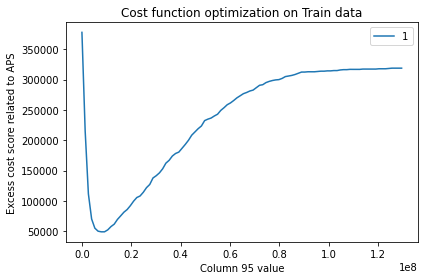

best value of column '95' from train data: 7773301.3731685
score on train data: 49140.0

Best values from 5 train sets: [9225825.469570167, 10265016.124660507, 9225446.934447868, 7773658.7300945185, 7773301.3731685]

Average best value of column '95' from train data: 8852649.726388311

Score on test data: 13020


In [31]:
optimize_cost(X_train,y_train,X_test,y_test,'95')

In [32]:
def optimize_cost(X_train,y_train,X_test,y_test,col):     
    bv = (X_train[col].max()+X_train[col].min())/2
    gap = np.abs(bv)
    lc = 0
    bestvalue = []
    flag = 0
    while(bv-gap != bv+gap):
        flag += 1
        for i in np.arange(bv-gap,bv+gap,(2*gap)/(100/flag**2)):
            temp=X_train[col].copy()
            temp.values[:]=1
            temp[X_train[X_train[col]<i].index]=0
            cm = confusion_matrix(y_train,temp)
            score = cm[0][1]*10+cm[1][0]*500
            bestvalue.append((i,score))
        bestvaluedf = pd.DataFrame(bestvalue).set_index(0)
        bestvalue = []
        bv = float(bestvaluedf.idxmin().values)
        lce = float(bestvaluedf.min().values)
        gap = (np.abs(bv)*0.1)/flag**4
        if flag == 1:
            bestvaluedf.plot()
            plt.title('Cost function optimization on Train data')
            plt.ylabel('Excess cost score related to APS')
            plt.xlabel('Column {} value'.format(col))   
            plt.tight_layout()
        if ((bestvaluedf.max()/bestvaluedf.min()) < 1.001).values[0]:
            break
    print('best value of column \'{}\' from train data:'.format(col),bv)
    print('\nleast cost on train data:',lc)

    temp=X_test[col].copy()
    temp.values[:]=1
    temp[X_test[X_test[col]<bv].index]=0
    cm = confusion_matrix(y_test,temp)
    lc = cm[0][1]*10+cm[1][0]*500
    print('\nleast cost on test data:',lc);

best value of column '95' from train data: 9225446.934447868

least cost on train data: 0

least cost on test data: 13190


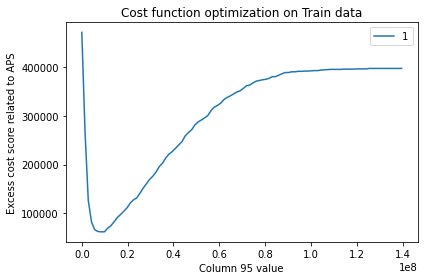

In [33]:
optimize_cost(X_train,y_train,X_test,y_test,'95')

In [37]:
Xpca = pd.read_pickle('Xpca.pickle')
y = pd.read_pickle('y.pickle')

In [3]:
Xpca.shape, y.shape

((52569, 91), (52569, 1))

c:\users\hari\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hari\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


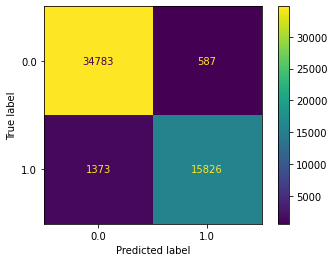

In [6]:
logreg = LogisticRegression(random_state=42)
logreg.fit(Xpca, y)
plot_confusion_matrix(logreg, Xpca, y)

In [6]:
logreg.score(Xpca, y)

0.9627156689303582

In [15]:
cm = confusion_matrix(y,logreg.predict(Xpca))
cm

array([[34783,   587],
       [ 1373, 15826]], dtype=int64)

In [16]:
fpr = cm[0][1]/cm[0].sum()
fnr = cm[1][0]/cm[1].sum()
fpr,fnr

(0.016595985298275374, 0.07983022268736555)

In [17]:
fpr*10+fnr*500

40.081071196665526

In [20]:
cm[0][1]*10+cm[1][0]*500 / len(y)

5883.059027183321

In [19]:
len(Xpca), len(y)

(52569, 52569)

In [4]:
df = pd.read_pickle('Cleaned Trucks Data.pickle')
df.drop('90',axis=1,inplace=True)
X = df.loc[:,'1':]
y = df[['class']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((48000, 169), (48000, 1), (12000, 169), (12000, 1))

In [5]:
def score_func(y, y_pred):
    cm = confusion_matrix(y,y_pred)
    score = (cm[0][1]*10+cm[1][0]*500) / cm.sum()
    return score

In [29]:
results = []
cachedir = mkdtemp()
for i in ['median','mean']:
    for j in [0.9,0.95,0.99]:
        for k in [0.5,0.7,0.9,1]:
            for l in [1,3,5]:
                for m in [5,10,15,20]:
                    for n in [0.001,0.01,0.1,0.5]:
                        for o in [0,0.4,1,5]:
                            for p in [0.5,0.7,0.9,1]:                    
                                imputer = SimpleImputer(strategy=i)#,IterativeImputer(random_state=42),KNNImputer()]
                                scaler = StandardScaler()
                                pca = PCA(n_components = j)
                                model = XGBClassifier(subsample= k,n_estimators=300,min_child_weight=l,max_depth=m,learning_rate=n,gamma=o,colsample_bytree=p,n_jobs=-1,verbosity=1)
                                oversampling = SMOTETomek(random_state=42)
                                scorer = make_scorer(score_func)  
                                pipeline = ImbPipeline(steps=[('i', imputer),('o',oversampling),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)
                                pipeline.fit(X_train,y_train.values.ravel())
                                trainscore = score_func(y_train,pipeline.predict(X_train))
                                testscore = score_func(y_test,pipeline.predict(X_test))
                                results.append((trainscore,testscore,i,j,k,l,m,n,o,p))
                                print(results[-1])
rmtree(cachedir)

[Pipeline] ................. (step 1 of 5) Processing i, total=   1.9s
[Pipeline] ................. (step 2 of 5) Processing o, total= 2.6min
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.4s
[Pipeline] ................. (step 4 of 5) Processing p, total=   3.8s
[Pipeline] ................. (step 5 of 5) Processing m, total=  36.4s
(0.773125, 0.7941666666666667, 'median', 0.9, 0.5, 1, 5, 0.001, 0, 0.5)
[Pipeline] ................. (step 5 of 5) Processing m, total=  49.3s
(0.7160416666666667, 0.72, 'median', 0.9, 0.5, 1, 5, 0.001, 0, 0.7)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.1min
(0.7316666666666667, 0.7025, 'median', 0.9, 0.5, 1, 5, 0.001, 0, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.1min
(0.7552083333333334, 0.785, 'median', 0.9, 0.5, 1, 5, 0.001, 0, 1)
[Pipeline] ................. (step 5 of 5) Processing m, total=  39.2s
(0.773125, 0.7941666666666667, 'median', 0.9, 0.5, 1, 5, 0.001, 0.4, 0.5)
[Pipeline]

(0.02125, 1.245, 'median', 0.9, 0.5, 1, 5, 0.5, 0.4, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.2min
(0.021875, 1.4816666666666667, 'median', 0.9, 0.5, 1, 5, 0.5, 0.4, 1)
[Pipeline] ................. (step 5 of 5) Processing m, total=  40.2s
(0.031875, 1.4541666666666666, 'median', 0.9, 0.5, 1, 5, 0.5, 1, 0.5)
[Pipeline] ................. (step 5 of 5) Processing m, total=  52.9s
(0.03166666666666667, 1.4558333333333333, 'median', 0.9, 0.5, 1, 5, 0.5, 1, 0.7)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.4min
(0.031875, 1.1566666666666667, 'median', 0.9, 0.5, 1, 5, 0.5, 1, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.5min
(0.03208333333333333, 1.3691666666666666, 'median', 0.9, 0.5, 1, 5, 0.5, 1, 1)
[Pipeline] ................. (step 5 of 5) Processing m, total=  41.2s
(0.06479166666666666, 1.4366666666666668, 'median', 0.9, 0.5, 1, 5, 0.5, 5, 0.5)
[Pipeline] ................. (step 5 of 5) Processing m, total=  

KeyboardInterrupt: 

In [33]:
pd.DataFrame(results).sort_values(1)[:5]

,0,1,2,3,4,5,6,7,8,9
14,0.731667,0.702500,median,0.9,0.5,1,5,0.001,5.0,0.9
2,0.731667,0.702500,median,0.9,0.5,1,5,0.001,0.0,0.9
6,0.731667,0.702500,median,0.9,0.5,1,5,0.001,0.4,0.9
10,0.731667,0.703333,median,0.9,0.5,1,5,0.001,1.0,0.9
31,0.553958,0.712500,median,0.9,0.5,1,5,0.010,5.0,1.0


In [34]:
results = []
cachedir = mkdtemp()
for i in ['median','mean']:
    for j in [0.9,0.95,0.99]:
        for k in [0.7,0.9]:
            for l in [1,3,5]:
                for m in [10,15,20]:
                    for n in [0.001]:
                        for o in [5]:
                            for p in [0.9]:                    
                                imputer = SimpleImputer(strategy=i)#,IterativeImputer(random_state=42),KNNImputer()]
                                scaler = StandardScaler()
                                pca = PCA(n_components = j)
                                model = XGBClassifier(subsample= k,n_estimators=300,min_child_weight=l,max_depth=m,learning_rate=n,gamma=o,colsample_bytree=p,n_jobs=-1,verbosity=1)
                                oversampling = SMOTETomek(random_state=42)
                                scorer = make_scorer(score_func)  
                                pipeline = ImbPipeline(steps=[('i', imputer),('o',oversampling),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)
                                pipeline.fit(X_train,y_train.values.ravel())
                                trainscore = score_func(y_train,pipeline.predict(X_train))
                                testscore = score_func(y_test,pipeline.predict(X_test))
                                results.append((trainscore,testscore,i,j,k,l,m,n,o,p))
                                print(results[-1])
rmtree(cachedir)

[Pipeline] ................. (step 1 of 5) Processing i, total=   1.3s
[Pipeline] ................. (step 2 of 5) Processing o, total= 2.6min
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.4s
[Pipeline] ................. (step 4 of 5) Processing p, total=   3.7s
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.6min
(0.363125, 0.8266666666666667, 'median', 0.9, 0.7, 1, 10, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 3.7min
(0.23458333333333334, 1.0225, 'median', 0.9, 0.7, 1, 15, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 4.2min
(0.21041666666666667, 1.0108333333333333, 'median', 0.9, 0.7, 1, 20, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.6min
(0.36916666666666664, 0.95, 'median', 0.9, 0.7, 3, 10, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 3.4min
(0.25666666666666665, 0.9516666666666667, 'median', 0.9, 0.7, 

KeyboardInterrupt: 

In [35]:
pd.DataFrame(results).sort_values(1)[:5]

,0,1,2,3,4,5,6,7,8,9
0,0.363125,0.826667,median,0.9,0.7,1,10,0.001,5,0.9
6,0.389167,0.839167,median,0.9,0.7,5,10,0.001,5,0.9
8,0.283958,0.884167,median,0.9,0.7,5,20,0.001,5,0.9
7,0.288958,0.887500,median,0.9,0.7,5,15,0.001,5,0.9
9,0.364792,0.939167,median,0.9,0.9,1,10,0.001,5,0.9


In [38]:
cachedir = mkdtemp()
for i in ['median','mean']:
    for j in [0.9,0.95,0.99]:
        for k in [0.3]:
            for l in [1,3,5]:
                for m in [10,15,20]:
                    for n in [0.001]:
                        for o in [5]:
                            for p in [0.9]:                    
                                imputer = SimpleImputer(strategy=i)#,IterativeImputer(random_state=42),KNNImputer()]
                                scaler = StandardScaler()
                                pca = PCA(n_components = j)
                                model = XGBClassifier(subsample= k,n_estimators=300,min_child_weight=l,max_depth=m,learning_rate=n,gamma=o,colsample_bytree=p,n_jobs=-1,verbosity=1)
                                oversampling = SMOTETomek(random_state=42)
                                scorer = make_scorer(score_func)  
                                pipeline = ImbPipeline(steps=[('i', imputer),('o',oversampling),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)
                                pipeline.fit(X_train,y_train.values.ravel())
                                trainscore = score_func(y_train,pipeline.predict(X_train))
                                testscore = score_func(y_test,pipeline.predict(X_test))
                                results.append((trainscore,testscore,i,j,k,l,m,n,o,p))
                                print(results[-1])
rmtree(cachedir)

[Pipeline] ................. (step 1 of 5) Processing i, total=   1.4s
[Pipeline] ................. (step 2 of 5) Processing o, total= 2.5min
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.4s
[Pipeline] ................. (step 4 of 5) Processing p, total=   3.4s
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.6min
(0.41375, 0.7683333333333333, 'median', 0.9, 0.3, 1, 10, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.1min
(0.33791666666666664, 0.7433333333333333, 'median', 0.9, 0.3, 1, 15, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.4min
(0.32958333333333334, 0.74, 'median', 0.9, 0.3, 1, 20, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 1.6min
(0.4297916666666667, 0.7425, 'median', 0.9, 0.3, 3, 10, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.1min
(0.37958333333333333, 0.6875, 'median', 0.9, 0.3, 3, 15, 0.001, 

[Pipeline] ................. (step 5 of 5) Processing m, total= 4.5min
(0.34020833333333333, 0.7308333333333333, 'mean', 0.99, 0.3, 3, 20, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 2.9min
(0.43833333333333335, 0.77, 'mean', 0.99, 0.3, 5, 10, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 3.8min
(0.38375, 0.715, 'mean', 0.99, 0.3, 5, 15, 0.001, 5, 0.9)
[Pipeline] ................. (step 5 of 5) Processing m, total= 4.2min
(0.383125, 0.715, 'mean', 0.99, 0.3, 5, 20, 0.001, 5, 0.9)


In [41]:
pd.DataFrame(results).sort_values(1)[:20]

,0,1,2,3,4,5,6,7,8,9
39,0.341875,0.620833,median,0.99,0.3,3,15,0.001,5.0,0.9
34,0.422708,0.621667,median,0.95,0.3,5,20,0.001,5.0,0.9
33,0.423125,0.621667,median,0.95,0.3,5,15,0.001,5.0,0.9
38,0.399167,0.633333,median,0.99,0.3,3,10,0.001,5.0,0.9
31,0.375417,0.636667,median,0.95,0.3,3,20,0.001,5.0,0.9
30,0.376042,0.638333,median,0.95,0.3,3,15,0.001,5.0,0.9
43,0.385625,0.643333,median,0.99,0.3,5,20,0.001,5.0,0.9
42,0.387083,0.644167,median,0.99,0.3,5,15,0.001,5.0,0.9
41,0.432292,0.649167,median,0.99,0.3,5,10,0.001,5.0,0.9
40,0.336667,0.658333,median,0.99,0.3,3,20,0.001,5.0,0.9


In [60]:
cachedir = mkdtemp()
for i in ['median']:
    for j in [0.95]:
        for k in [0.5]:
            for l in [5]:
                for m in [20]:
                    for n in [0.001]:
                        for o in [5]:
                            for p in [0.9]:                    
                                imputer = SimpleImputer(strategy=i)#,IterativeImputer(random_state=42),KNNImputer()]
                                scaler = StandardScaler()
                                pca = PCA(n_components = j)
                                model = XGBClassifier(subsample= k,n_estimators=300,min_child_weight=l,max_depth=m,learning_rate=n,gamma=o,colsample_bytree=p,n_jobs=-1,verbosity=1)
                                oversampling = SMOTETomek(random_state=42)
                                scorer = make_scorer(score_func)  
                                pipeline = ImbPipeline(steps=[('i', imputer),('o',oversampling),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)
                                pipeline.fit(X_train,y_train.values.ravel())
                                trainscore = score_func(y_train,pipeline.predict(X_train))
                                testscore = score_func(y_test,pipeline.predict(X_test))
                                print(trainscore,testscore,i,j,k,l,m,n,o,p)
                                
rmtree(cachedir)

[Pipeline] ................. (step 1 of 5) Processing i, total=   0.2s
[Pipeline] ................. (step 2 of 5) Processing o, total=  14.0s
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.1s
[Pipeline] ................. (step 4 of 5) Processing p, total=   0.7s
[Pipeline] ................. (step 5 of 5) Processing m, total=  27.3s
1.4858333333333333 0.37666666666666665 median 0.95 0.5 5 20 0.001 5 0.9


In [43]:
results.append((0.31854166666666667, 0.705, 'median', 0.95, 0.5, 5, 20, 0.001, 5, 0.9))

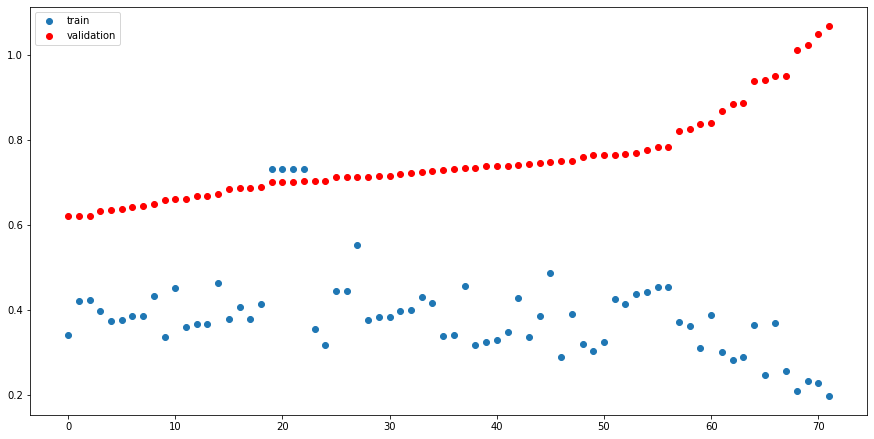

In [59]:
plt.figure(figsize=(15,7.5))
plt.scatter(x=range(72),y=pd.DataFrame(results).sort_values(1)[[0]],label='train')
plt.scatter(x=range(72),y=pd.DataFrame(results).sort_values(1)[[1]],c='r',label='validation')
plt.legend();

In [211]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
pca = PCA(n_components = 0.9)
model = XGBClassifier(scale_pos_weight=59,subsample= 0.3,n_estimators=300,min_child_weight=3,max_depth=15,learning_rate=0.001,gamma=5,colsample_bytree=0.9,n_jobs=-1,verbosity=1)
oversampling = SMOTETomek(random_state=42)
#scorer = make_scorer(score_func)  

#pipeline = ImbPipeline(steps=[('i', imputer),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)

pipeline = ImbPipeline(steps=[('i', SimpleImputer(strategy='median')),
                  ('o', SMOTETomek(random_state=42)), ('s', StandardScaler()),
                  ('p', PCA(n_components=0.95)),
                  ('m',
                   XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=0.6, gamma=2.0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='', learning_rate=0.5,
                                 max_delta_step=0, max_depth=4,
                                 min_child_weight=2,
                                 monotone_constraints='()', n_estimators=400,
                                 n_jobs=-1, num_parallel_tree=1, random_state=42,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                 subsample=0.4, tree_method='exact',
                                 validate_parameters=1, verbosity=1))],
           verbose=True)

pipeline.fit(X,y.values.ravel())
#0.9	0.5	1	5	0.001	5.0	0.9 ,('s', scaler),('p', pca),('o',oversampling)
#0.99	0.3	3	15	0.001	5.0	0.9 scale_pos_weight=59,

[Pipeline] ................. (step 1 of 5) Processing i, total=   0.8s
[Pipeline] ................. (step 2 of 5) Processing o, total=  29.6s
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.4s
[Pipeline] ................. (step 4 of 5) Processing p, total=   1.9s
[Pipeline] ................. (step 5 of 5) Processing m, total=  22.4s


Pipeline(steps=[('i', SimpleImputer(strategy='median')),
                ('o', SMOTETomek(random_state=42)), ('s', StandardScaler()),
                ('p', PCA(n_components=0.95)),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=2.0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.5,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=400,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.4, tree_method='exact',
                         

In [212]:
fpr,tpr, thresholds = roc_curve(y, pipeline.predict_proba(X)[:,1])

In [213]:
mymetric = fpr + (1-tpr)

In [214]:
np.argmin(mymetric)

166

Best Threshold: 0.55317885


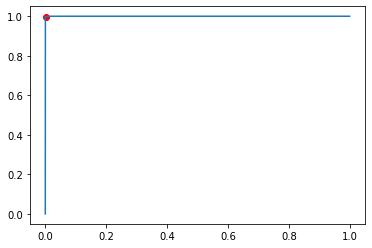

In [215]:
plt.plot(fpr,tpr)
plt.scatter(fpr[np.argmin(mymetric)],tpr[np.argmin(mymetric)],c='r')
print('Best Threshold:',thresholds[np.argmin(mymetric)])

In [216]:
cm = confusion_matrix(testy,(pipeline.predict(testX)))
cm[0][1]*10+cm[1][0]*500

34030

In [217]:
cm = confusion_matrix(testy,(pipeline.predict_proba(testX)[:,1] >= thresholds[np.argmin(mymetric)]).astype(bool))
cm[0][1]*10+cm[1][0]*500

34870

Best threshold: 0.47100824


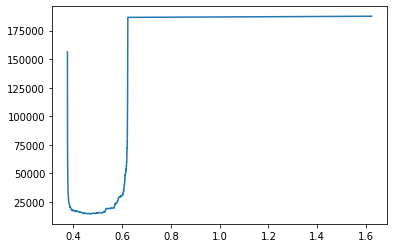

In [52]:
costs = []
for t in thresholds:
    cm = confusion_matrix(testy,(pipeline.predict_proba(testX)[:,1] >= t).astype(bool))
    costs.append(cm[0][1]*10+cm[1][0]*500)
plt.plot(thresholds,costs)
print('Best threshold:', thresholds[np.argmin(costs)])

In [95]:
search_space = [Real(0.5,0.6,0.7,0.8,0.9,0.95,0.99, name='p__n_components'), 
                Real(0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, name='m__subsample'),
                Real(100,200,300,400, name='m__n_estimators'),
                Real(1,2,3,4,5,6,7,8,9,10, name='m__min_child_weight'),
                Real(3,5,7,9,11,15,22, name='m__max_depth'),
                Real(0.0001,0.001,0.005,0.01,0.05,0.1,0.2,0.5, name='m__learning_rate'),
                Real(0,1,2,3,4,5,10, name='m__gamma'),
                Real(0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, name='m__colsample_bytree')]
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
pca = PCA()
model = XGBClassifier(n_jobs=-1,verbosity=1)
oversampling = SMOTETomek(random_state=42)
scorer = make_scorer(score_func)  
pipeline = ImbPipeline(steps=[('i', imputer),('o',oversampling),('s', scaler),('p', pca), ('m', model)],verbose=True,memory=cachedir)

@use_named_args(search_space)
def evaluate_model(**params):
    pipeline.set_params(**params)
    result = cross_val_score(pipeline, X, y.values.ravel(), cv=5, n_jobs=-1, scoring=scorer)
    estimate = np.mean(result)
    return estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Score:',result.fun)
print('Best Parameters:',result.x)

TypeError: __init__() got multiple values for argument 'name'

In [81]:
score_func(y_train,pipeline.predict(X_train))


0.7725

In [71]:
cm

array([[15189,   436],
       [   38,   337]], dtype=int64)

In [13]:
cm = confusion_matrix(testy,pipeline.predict(testX))
cm[0][1]*10+cm[1][0]*500

14920

In [82]:
cm

array([[14870,   755],
       [   16,   359]], dtype=int64)

In [208]:
bayesresult = []
imp = SimpleImputer(strategy='median')#,IterativeImputer(random_state=42),KNNImputer()]
scaler = StandardScaler()
pca = PCA()
model = XGBClassifier(random_state=42,n_jobs=-1,verbosity=1)
over = SMOTETomek(random_state=42)
cachedir = mkdtemp()
scorer = make_scorer(score_func)   
params =    {'m__learning_rate'    : [0.0001,0.001,0.005,0.01,0.05,0.1,0.2,0.5 ] ,
                 'm__max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15,20,25],
                 'm__min_child_weight' : [ 1,2,3,4,5,6,7,8,9,10 ],
                 'm__gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4,0.5,1,2,3,4,5,10 ],
                 'm__colsample_bytree' : [ 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0 ], 
                 'm__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
                 'm__subsample': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                 'p__n_components':[0.85,0.9,0.925,0.95,0.99]}
                
pipeline = ImbPipeline(steps=[('i', imp),('o',over),('s', scaler),('p', pca), ('m', model)],verbose=True)
bs = BayesSearchCV(pipeline,params,scoring=scorer,cv=3,n_jobs=-1,n_points=5,verbose=1)
bs.fit(X,y.values.ravel())
bayesresult.append((bs.best_estimator_,bs.best_score_,bs.cv_results_['std_test_score'][bs.best_index_]))
with open('BayesResult.pkl', 'wb') as f:
    pickle.dump(bayesresult, f)
                        
rmtree(cachedir)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.3min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.7min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.2min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.2min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 10.8min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  9.2min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.6min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.1min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.4min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.7min finished


[Pipeline] ................. (step 1 of 5) Processing i, total=   0.7s
[Pipeline] ................. (step 2 of 5) Processing o, total=  27.4s
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.2s
[Pipeline] ................. (step 4 of 5) Processing p, total=   1.5s
[Pipeline] ................. (step 5 of 5) Processing m, total=  22.9s


In [209]:
bayesresult

[(Pipeline(steps=[('i', SimpleImputer(strategy='median')),
                  ('o', SMOTETomek(random_state=42)), ('s', StandardScaler()),
                  ('p', PCA(n_components=0.95)),
                  ('m',
                   XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=0.6, gamma=2.0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='', learning_rate=0.5,
                                 max_delta_step=0, max_depth=4,
                                 min_child_weight=2, missing=nan,
                                 monotone_constraints='()', n_estimators=400,
                                 n_jobs=-1, num_parallel_tree=1, random_state=42,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                 subsample=0.4, tree_method='exa

In [9]:
bestpipe = ImbPipeline(steps=[('i', SimpleImputer(strategy='median')),
                  ('o', SMOTETomek(random_state=42)), ('s', StandardScaler()),
                  ('p', PCA(n_components=0.7)),
                  ('m',
                   XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='', learning_rate=0.2,
                                 max_delta_step=0, max_depth=15,
                                 min_child_weight=9,
                                 monotone_constraints='()', n_estimators=300,
                                 n_jobs=-1, num_parallel_tree=1, random_state=42,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                 subsample=0.7, tree_method='exact',
                                 validate_parameters=1, verbosity=2))],
           verbose=True)
bestpipe.fit(X,y.values.ravel())

[Pipeline] ................. (step 1 of 5) Processing i, total=   2.0s
[Pipeline] ................. (step 2 of 5) Processing o, total= 4.3min
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.6s
[Pipeline] ................. (step 4 of 5) Processing p, total=   5.2s
[16:00:40] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 542 extra nodes, 14 pruned nodes, max_depth=15
[16:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 444 extra nodes, 12 pruned nodes, max_depth=15
[16:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 452 extra nodes, 28 pruned nodes, max_depth=15
[16:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 518 extra nodes, 26 pruned nodes, max_depth=15
[16:00:41] INFO: C:\

[16:00:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[16:00:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 80 extra nodes, 2 pruned nodes, max_depth=15
[16:00:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=15
[16:00:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 170 extra nodes, 4 pruned nodes, max_depth=15
[16:00:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 188 extra nodes, 2 pruned nodes, max_depth=15
[16:00:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 168 extra n

[16:01:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 106 extra nodes, 2 pruned nodes, max_depth=13
[16:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=15
[16:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 80 extra nodes, 2 pruned nodes, max_depth=15
[16:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 96 extra nodes, 2 pruned nodes, max_depth=15
[16:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=15
[16:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nod

[16:01:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 70 extra nodes, 2 pruned nodes, max_depth=12
[16:01:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 72 extra nodes, 6 pruned nodes, max_depth=14
[16:01:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 4 pruned nodes, max_depth=15
[16:01:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=15
[16:01:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 6 pruned nodes, max_depth=13
[16:01:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 54 extra node

[16:01:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 14 pruned nodes, max_depth=14
[16:01:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nodes, 4 pruned nodes, max_depth=12
[16:01:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 6 pruned nodes, max_depth=15
[16:01:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 6 pruned nodes, max_depth=8
[16:01:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 12 pruned nodes, max_depth=13
[16:01:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 52 extra nod

[16:01:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 18 pruned nodes, max_depth=12
[16:01:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 18 pruned nodes, max_depth=9
[16:01:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 28 pruned nodes, max_depth=7
[16:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 14 pruned nodes, max_depth=11
[16:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 8 pruned nodes, max_depth=7
[16:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nod

[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 8 pruned nodes, max_depth=15
[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 14 pruned nodes, max_depth=12
[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 10 pruned nodes, max_depth=9
[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 18 pruned nodes, max_depth=10
[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 26 pruned nodes, max_depth=5
[16:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra no

Pipeline(steps=[('i', SimpleImputer(strategy='median')),
                ('o', SMOTETomek(random_state=42)), ('s', StandardScaler()),
                ('p', PCA(n_components=0.7)),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=15,
                               min_child_weight=9, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                         

In [11]:
cm = confusion_matrix(testy,bestpipe.predict(testX))
cm[0][1]*10+cm[1][0]*500

24310

In [58]:
rs.best_estimator_,rs.best_score_,rs.cv_results_['std_test_score'][rs.best_index_]

(Pipeline(steps=[('i', SimpleImputer()), ('o', SMOTETomek(random_state=42)),
                 ('s', StandardScaler()), ('p', PCA(n_components=0.9)),
                 ('m',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='', learning_rate=0.5,
                                max_delta_step=0, max_depth=3,
                                min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=200,
                                n_jobs=-1, num_parallel_tree=1, random_state=42,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                subsample=0.3, tree_method='exact',
                                validate_para

In [59]:
rs.best_estimator_.fit(X,y)

[Pipeline] ................. (step 1 of 5) Processing i, total=   0.3s
[Pipeline] ................. (step 2 of 5) Processing o, total= 2.6min
[Pipeline] ................. (step 3 of 5) Processing s, total=   0.5s
[Pipeline] ................. (step 4 of 5) Processing p, total=   4.3s


c:\users\hari\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:19:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:20:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

Pipeline(steps=[('i', SimpleImputer()), ('o', SMOTETomek(random_state=42)),
                ('s', StandardScaler()), ('p', PCA(n_components=0.9)),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.5,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.3, tree_method='exact',
                               validate_parameters=1, verbo

In [60]:
cm = confusion_matrix(testy,rs.predict(testX))
cm[0][1]*10+cm[1][0]*500

33320

In [ ]:
xgb = XBGClassifier()

In [8]:
y_pred = rs.predict(X_test)

In [10]:
cm = confusion_matrix(y_test,y_pred)
#score = (cm[0][1]*10+cm[1][0]*500) / cm.sum()
cm

array([[11656,   144],
       [   25,   175]], dtype=int64)

In [11]:
cm[0][1]*10+cm[1][0]*500

13940

In [121]:
test = pd.read_csv('C:\\Users\\Hari\\Downloads\\aps_failure_test_set.csv',skiprows=20,na_values='na')
test.columns = ['class',*[str(x) for x in range(1,171)]]
test['class'].replace({'neg':0,'pos':1},inplace=True)
test.drop('90',axis=1,inplace=True)
#testX = test.loc[:,'1':]
testy = test[['class']]
testX = test.loc[:,corrs[corrs.abs()>0.3].index]

In [42]:
cm = confusion_matrix(testy,rs.predict(testX))
cm[0][1]*10+cm[1][0]*500

24920

In [44]:
temp=testX['95'].copy()
temp.values[:]=1
temp[testX[testX['95']<8852649.726388311].index]=0
cm = confusion_matrix(testy,temp)
score = cm[0][1]*10+cm[1][0]*500
#score = lc / cm.sum()
#print('\nleast cost on test data:',lc)
print('\nScore on test data:',score);


Score on test data: 19190


In [46]:
posmask = df['class']==1
negmask = df['class']==0

In [19]:
Xreal.shape,yreal.shape

((60000, 169), (60000, 1))

In [4]:
scaler = StandardScaler()
Xreal = scaler.fit_transform(Xreal)
pca = PCA(n_components = 0.99)
Xreal = pca.fit_transform(Xreal)

In [54]:
logreg = LogisticRegression(random_state=42)
scaler = StandardScaler()
pca = PCA(n_components = 0.99)
scorer = make_scorer(score_func, greater_is_better=False)
clf = make_pipeline(scaler, pca, logreg)
cross_val_score(clf, Xreal, yreal,scoring=scorer,n_jobs=-1,cv=7)

array([-213.32467746, -188.83966194, -188.83491642, -186.6446323 ,
       -192.33972838, -171.37138609, -206.31980976])

In [44]:
scaled = scaler.fit_transform(Xreal)
pcaed = pca.fit_transform(scaled)
logreg.fit(pcaed, yreal)

c:\users\hari\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hari\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

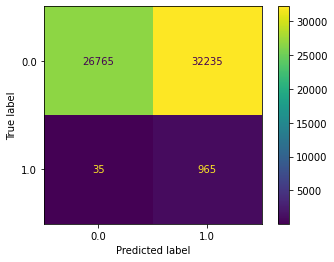

In [12]:
plot_confusion_matrix(logreg, Xreal[:,:91], yreal)

In [21]:
cm = confusion_matrix(yreal,logreg.predict(Xreal[:,:91]))
fpr = cm[0][1]/cm[0].sum()
fnr = cm[1][0]/cm[1].sum()
fpr,fnr

(0.5463559322033898, 0.035)

In [ ]:
fpr*10+fnr*500

In [22]:
len(Xreal[:,:91])

60000

In [29]:
cm[0][1]*10+cm[1][0]*500

339850